20180634_최준혁_과제5

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt 
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns 
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
                            f1_score, confusion_matrix ,classification_report,ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, validation_curve, train_test_split
from sklearn.preprocessing import MinMaxScaler ,FunctionTransformer
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Telco Customer Churn Dataset 2
- 과제 4에서 정리한 자료를 이용하여 decision tree와 ensemble 모형을 훈련한다.
- 표본을 훈련자료와 검증자료로 나누어 검증자료에 대한 예측력을 기준으로 모형들을 비교한다.

In [2]:
data = pd.read_pickle('churn.pkl') ; churn =data.copy()

In [3]:
churn

,Churn,tenure,MonthlyCharges,TotalCharges,SeniorCitizen,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_Yes,...,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,29,29,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,1,0
1,0,34,56,1889,0,1,0,0,1,0,...,1,0,0,0,1,0,0,0,0,1
2,1,2,53,108,0,1,0,0,1,0,...,0,0,0,0,0,0,1,0,0,1
3,0,45,42,1840,0,1,0,0,0,0,...,1,1,0,0,1,0,0,0,0,0
4,1,2,70,151,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0,24,84,1990,0,1,1,1,1,1,...,1,1,1,1,1,0,1,0,0,1
7039,0,72,103,7362,0,0,1,1,1,1,...,1,0,1,1,1,0,1,1,0,0
7040,0,11,29,346,0,0,1,1,0,0,...,0,0,0,0,0,0,1,0,1,0
7041,1,4,74,306,1,1,1,0,1,1,...,0,0,0,0,0,0,1,0,0,1


In [4]:
#함수 정의
def ploting_cf_matrix(y_test,pred, title = "title"):
    cf_matrix = confusion_matrix(y_test,pred)
    plt.figure(figsize = (4,3))
    sns.heatmap(cf_matrix, annot=True,fmt='.1f',cmap = 'Greens')
    plt.title(title ,fontsize= 15)
    plt.xlabel('pred') ; plt.ylabel('actual')
    plt.show()
    print("ACCURACY :",accuracy_score(y_test,pred)) 
    print("RECALL :",recall_score(y_test,pred)) 
    print("PRECISION :",precision_score(y_test,pred)) 
    print("F1_SCORE :",f1_score(y_test,pred)) 

##  Decision tree
- GridSearchCV로 max_depth와 ccp_alpha 최적값을 찾는다.
- Test data를 이용해 training data로 훈련한 최적모형의 성과를 확인한다.

In [5]:
from sklearn.tree import DecisionTreeClassifier

y = churn['Churn']
X = churn.iloc[:,1:]
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, test_size = 0.2, random_state = 100)

dtreeCLF =  Pipeline(steps = [('scaler', MinMaxScaler()),('dtreeCLF',DecisionTreeClassifier())])
cv = 8
scoring = "f1_macro" #roc_auc

param_grid = [{'dtreeCLF__max_depth': [6,12,18,24,30,36,42,48],
               'dtreeCLF__ccp_alpha':np.linspace(1e-6, 2, 20)}]

dtreeCLF_gs = GridSearchCV(dtreeCLF, param_grid = param_grid,cv=cv, scoring=scoring, return_train_score = True)
dtreeCLF_gs.fit(x_train, y_train)

print("best parameter, best score")
print(dtreeCLF_gs.best_params_, dtreeCLF_gs.best_score_)

best parameter, best score
{'dtreeCLF__ccp_alpha': 1e-06, 'dtreeCLF__max_depth': 6} 0.720875845026267


ACCURACY : 0.7778566359119943
RECALL : 0.5572916666666666
PRECISION : 0.5994397759103641
F1_SCORE : 0.5775978407557355


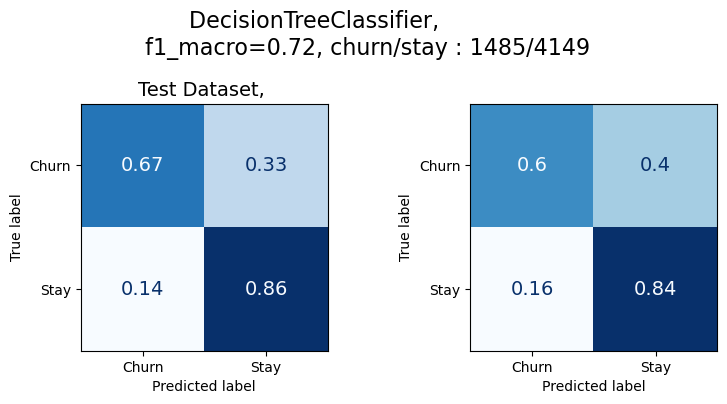

In [6]:
fig, (ax0, ax1) = plt.subplots(1,2, figsize = (8,4))
plt.rc('font',size = 14)
y_pred =dtreeCLF_gs.predict(x_train)
ConfusionMatrixDisplay.from_predictions(y_pred, y_train, normalize = "true",
                                       labels =[1,0], display_labels = ["Churn","Stay"],
                                       cmap = "Blues", ax = ax0, colorbar = False)
ax0.set_title(f"Training Dataset, ", fontsize = 14)

y_pred =dtreeCLF_gs.predict(x_test)
ConfusionMatrixDisplay.from_predictions(y_pred, y_test, normalize = "true",
                                       labels =[1,0], display_labels = ["Churn","Stay"],
                                       cmap = "Blues", ax = ax1, colorbar = False)
ax0.set_title(f"Test Dataset, ", fontsize = 14)

fig.suptitle(f"DecisionTreeClassifier, \
             \n {scoring}={dtreeCLF_gs.best_score_:.2f}, churn/stay : {sum(y_train)}/{sum(1-y_train)}", fontsize = 16)
fig.tight_layout()
print("ACCURACY :",accuracy_score(y_test,y_pred)) 
print("RECALL :",recall_score(y_test,y_pred)) 
print("PRECISION :",precision_score(y_test,y_pred)) 
print("F1_SCORE :",f1_score(y_test,y_pred)) 

## Ensemble

In [7]:
# Train Test나눈 후 MinMaxScaling하여 이 자료를 계속 모형에 사용
y = churn['Churn']
X = churn.iloc[:,1:]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, test_size = 0.2, random_state = 100)

features = X_train.columns.values
scaler = MinMaxScaler(feature_range = (0,1))
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train))
X_train.columns = features

features = X_test.columns.values
scaler = MinMaxScaler(feature_range = (0,1))
scaler.fit(X_test)
X_test = pd.DataFrame(scaler.transform(X_test))
X_test.columns = features

###  Bagging
- 적당한 weak learner를 선택하여 random foreset 모형을 훈련시키고 test set에 대한 검증결과를 confusion matrix로 정리한다.

#### WAY1 : random forest

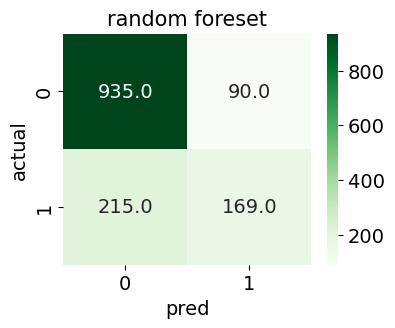

ACCURACY : 0.7835344215755855
RECALL : 0.4401041666666667
PRECISION : 0.6525096525096525
F1_SCORE : 0.5256609642301711


In [8]:
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier
rf_clf = RandomForestClassifier(n_estimators=500,max_samples = 1.0,
                                max_features = "auto", max_leaf_nodes =16,  n_jobs = -1)
rf_clf.fit(X_train, y_train)
rf_clf_pred = rf_clf.predict(X_test)
ploting_cf_matrix(y_test,rf_clf_pred, "random foreset")

#### WAY2 : bagging 

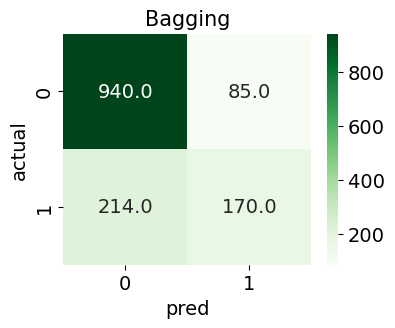

ACCURACY : 0.7877927608232789
RECALL : 0.4427083333333333
PRECISION : 0.6666666666666666
F1_SCORE : 0.5320813771517996


In [9]:
weak_learner = DecisionTreeClassifier(max_features = "auto",max_leaf_nodes =16)
bag_clf = BaggingClassifier(
    weak_learner,
    n_estimators = 500, max_samples = 1.0, bootstrap=True, n_jobs = -1
)
bag_clf.fit(X_train, y_train)
bag_clf_pred = bag_clf.predict(X_test)
ploting_cf_matrix(y_test,bag_clf_pred, "Bagging")

###  Adaboost
- 적당한 weak learner를 선택하여 Adaboost 모형을 훈련시키고 test set에 대한 검증결과를 confusion matrix로 정리한다.

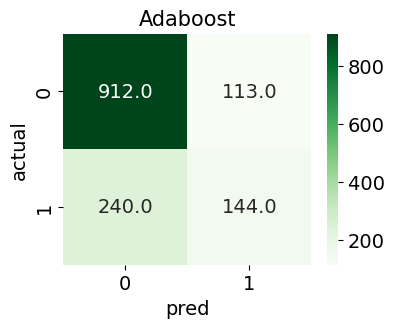

ACCURACY : 0.7494677075940384
RECALL : 0.375
PRECISION : 0.5603112840466926
F1_SCORE : 0.44929797191887677


In [10]:
from sklearn.ensemble import AdaBoostClassifier

weak_learner = DecisionTreeClassifier(max_depth =1)
ada_clf = AdaBoostClassifier(
    weak_learner, n_estimators=500
)
ada_clf.fit(X_train, y_train)
ada_clf_pred = ada_clf.predict(X_test)
ploting_cf_matrix(y_test,ada_clf_pred, "Adaboost")

### XGBoost
- 적당한 weak learner를 선택하여 XGBoost 모형을 훈련시키고 test set에 대한 검증결과를 confusion matrix로 정리한다.

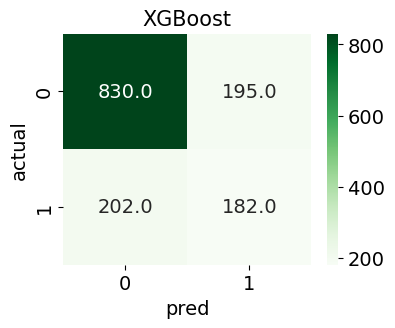

ACCURACY : 0.7182398864442867
RECALL : 0.4739583333333333
PRECISION : 0.4827586206896552
F1_SCORE : 0.4783180026281209


In [11]:
import xgboost as xgb 
from xgboost import plot_importance, XGBClassifier
X_train = X_train.astype(int)
X_test = X_test.astype(int)

xgb_clf = XGBClassifier(n_estimators=500,  n_jobs = -1)
xgb_clf.fit(X_train, y_train)
xgb_clf_pred = xgb_clf.predict(X_test)
ploting_cf_matrix(y_test,xgb_clf_pred, "XGBoost")

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

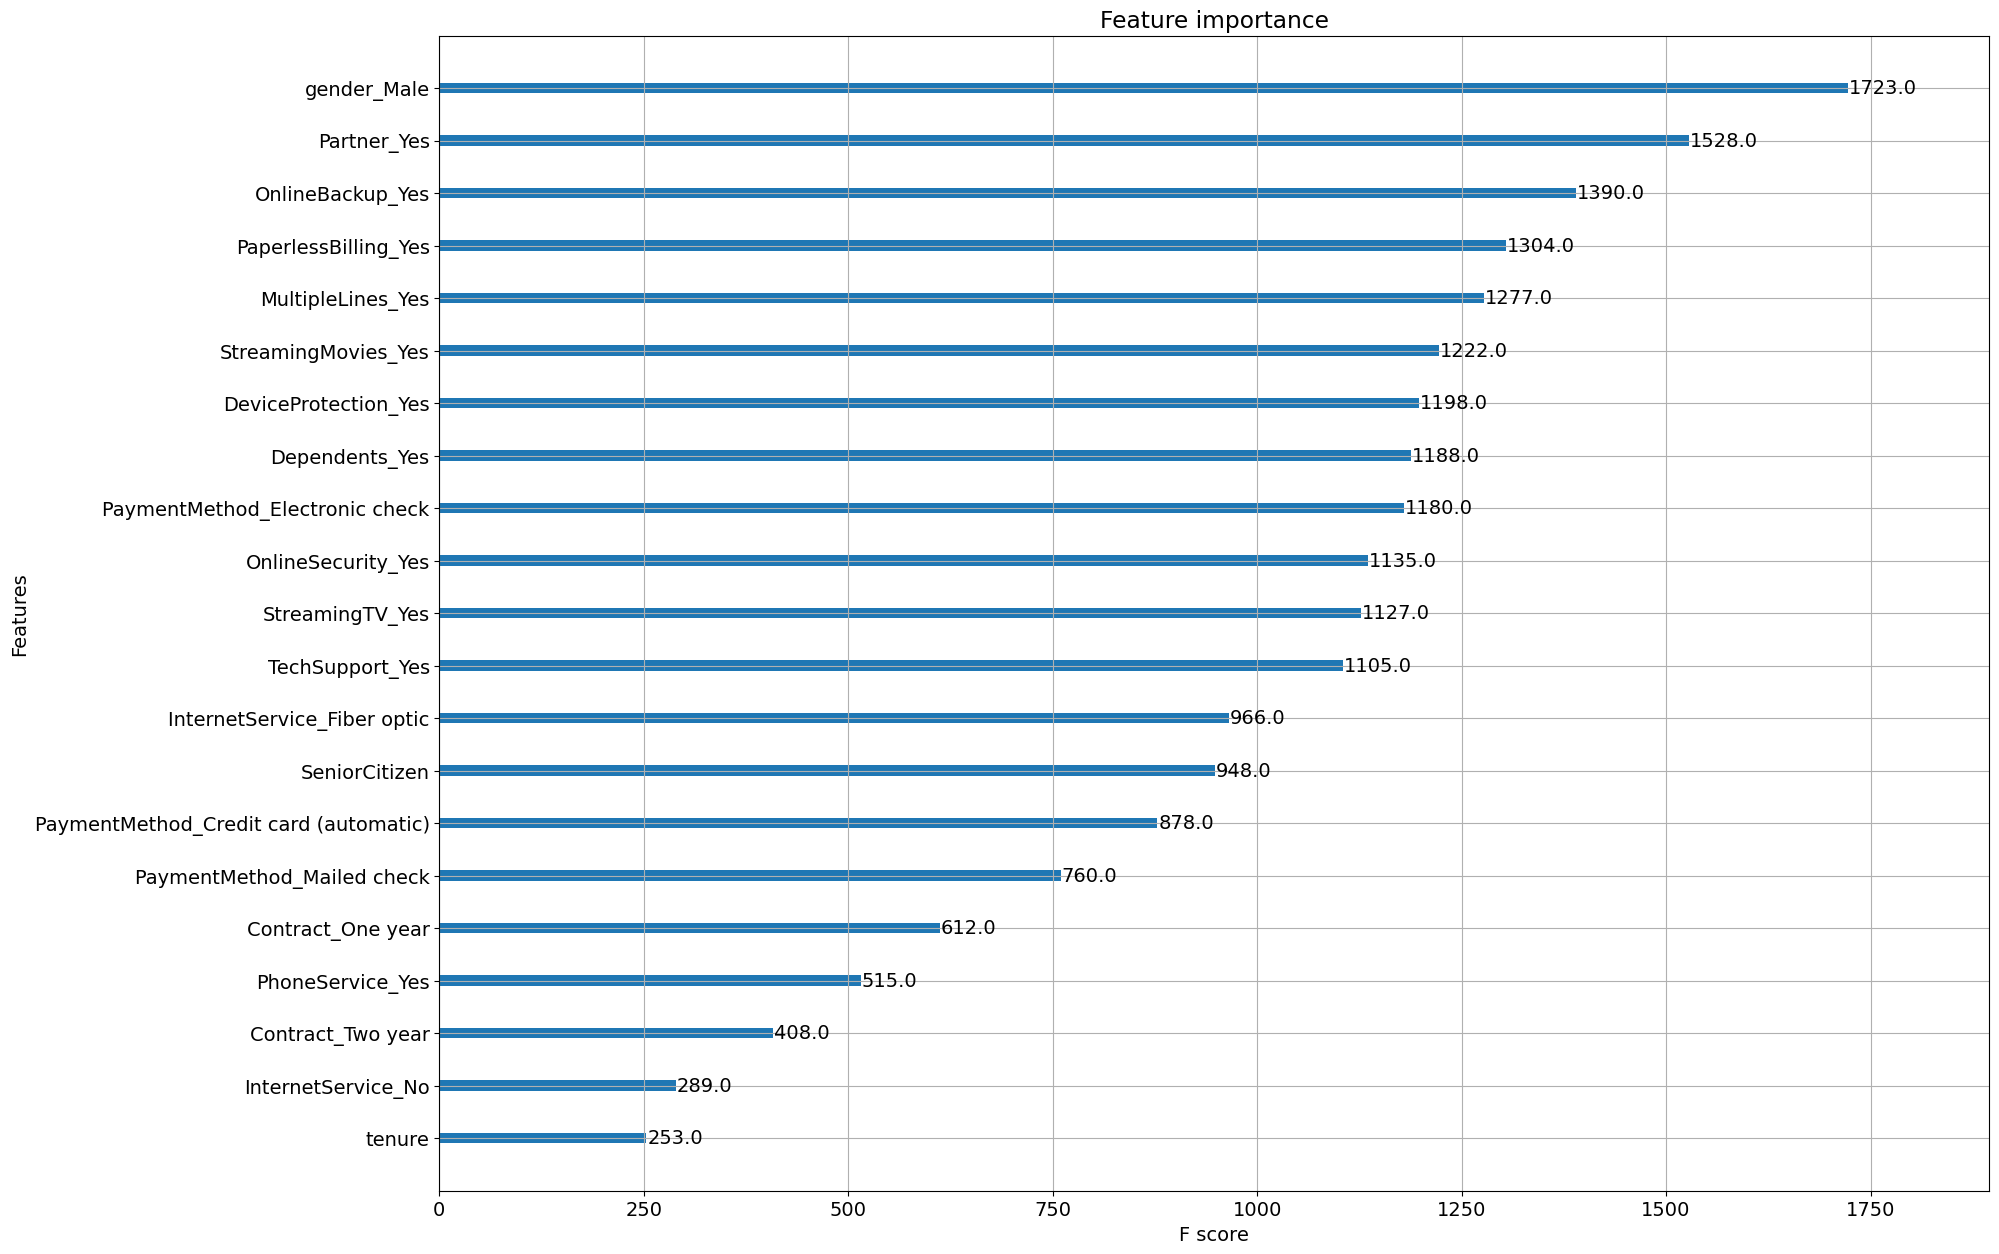

In [12]:
plt.figure(figsize=(20,15))
xgb.plot_importance(xgb_clf, ax=plt.gca())

### Stacking
- 적당한 base 모형과 meta 모형을 선택하여 stacking 모형을 훈련시키고 test set에 대한 검증결과를 confusion matrix로 정리한다.

rf_clf의 정확도 : 0.7715
ada_clf의 정확도 : 0.7622
xgb_clf 정확도 : 0.7182
dt_clf 정확도 : 0.7104

최종 메타 모델의 예측 정확도 : 0.7104


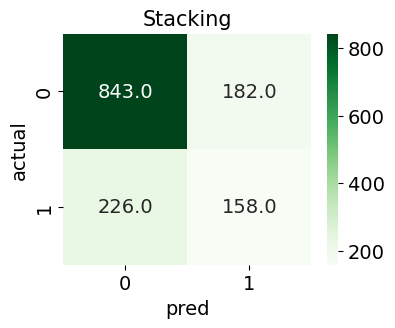

ACCURACY : 0.7104329311568488
RECALL : 0.4114583333333333
PRECISION : 0.4647058823529412
F1_SCORE : 0.43646408839779


In [13]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from lightgbm import LGBMClassifier

# 개별 ML 모델 생성
rf_clf = RandomForestClassifier(n_estimators=500,max_samples = 1.0,\
                                max_features = "auto", max_leaf_nodes =16,  n_jobs = -1)
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth =1), n_estimators=500)
xgb_clf = XGBClassifier(n_estimators=500, n_jobs = -1)
dt_clf = DecisionTreeClassifier()

# 스태킹으로 만들어진 데이터 세트를 학습, 예측할 최종 모델(블렌더 모델 생성)
lr_final = LGBMClassifier()

# 개별 모델들을 학습
rf_clf.fit(X_train, y_train)
ada_clf.fit(X_train, y_train)
xgb_clf.fit(X_train, y_train)
dt_clf.fit(X_train, y_train)

# 학습된 개별 모델들이 각자 반환하는 학습 데이터 세트를 생성
rf_clf_train= rf_clf.predict(X_train)
ada_clf_train = ada_clf.predict(X_train)
xgb_clf_train = xgb_clf.predict(X_train)
dt_clf_train = dt_clf.predict(X_train)

# 최종 학습 데이터 생성
train = np.array([rf_clf_train, ada_clf_train, xgb_clf_train, dt_clf_train])
train = np.transpose(train)

# 블렌더 학습
lr_final.fit(train, y_train)

# 개별 모델들이 각자 반환하는 예측 데이터 세트를 생성하고 개별 모델의 정확도 측정
rf_clf_pred = rf_clf.predict(X_test)
ada_clf_pred = ada_clf.predict(X_test)
xgb_clf_pred = xgb_clf.predict(X_test)
dt_clf_pred = dt_clf.predict(X_test)

print('rf_clf의 정확도 :',round(accuracy_score(y_test, rf_clf_pred),4))
print('ada_clf의 정확도 :',round(accuracy_score(y_test, ada_clf_pred),4))
print('xgb_clf 정확도 :',round(accuracy_score(y_test,xgb_clf_pred),4))
print('dt_clf 정확도 :',round(accuracy_score(y_test, dt_clf_pred),4))

# transpose를 이용해 행과 열의 위치 교환. 칼럼 레벨로 각 알고리즘의 예측결과를 피처로 만듦
pred = np.array([rf_clf_pred, ada_clf_pred, xgb_clf_pred, dt_clf_pred])
pred = np.transpose(pred)
final = lr_final.predict(pred)

print('\n최종 메타 모델의 예측 정확도 :', round(accuracy_score(y_test, final),4))
ploting_cf_matrix(y_test, final, "Stacking")